In [1]:
#| default_exp neighbor_contiguity
# from numba import config; config.DISABLE_JIT = True

# Neighbor Contiguity Analysis

> For spaced items (lag >= 4) in mixed lists with study positions $i$ and $j$, we determined the proportion of times, given that a subject made a transition between an item from an item in $S_i = {i + 1, i + 2}$ or $S_j = {j + 1, j + 2}$, that they would then transition to an item in $S_j$ or $S_i$, respectively. 
> 
> To control for the proportion of transitions expected in the absence of repeated items, we assigned the same serial positions used in the mixed lists to corresponding items in the control lists. For each subject, we assigned these positions to 100 random shuffles of the control lists, and took the mean across lists to get a baseline expectation of remote transitions.

## Implementation Approach
This is a somewhat complicated analysis, so we attempt to modularize key components of the analysis into distinct functions.

For my baseline `transition_analysis` function, I broke it down into the following pieces:
- transition tracking within and across trials
- tabulation over each transition
- filtering of tabulation to only include transitions of interest

The transition tracking is mostly the same, but may require a more complicated data structure since study lists have item repetitions and nonzero values in trial vectors now refer to (initial) study positions instead of item index.

The core objective of the filter function here is to only include transitions from $S_i$ or $S_j$.
To detect whether a transition is from $S_i$ or $S_j$, we need to know the serial positions of the items in the list.
We have to first know if a repeatedly studied item was studied either one or two positions before a study position of the previously recalled item.
We also have to confirm that the spacing between the two presentations of the item is at least 4.

For tabulation, we are only tracking one value per iteration: whether the transition was to the alternative of $S_i$ or $S_j$.
This requires checking whether the transitioned-to item follows the same repeatedly-presented item that makes the previously recalled item part of $S_i$ or $S_j$, but a different study position for the repeatedly-presented item.
For a denominator, we may also want to track whether recalling the appropriate of $S_i$ or $S_j$ was possible in the first place for the considered transition.

The control analysis similarly needs $S_i$ and $S_j$ study positions to be tracked across occurrences in a separate set of presentations (mixed lists instead of the control lists that responses were generated for).
This suggests that it might be a good idea to devote a specific function to building a data structure that identifies these across trials and makes tabulation easy without consideration of further consideration of item identities.
Instead, we can primarily identify $S_i$ and $S_j$ using their (initial) study positions in a function shared between main and control analyses.

## Identifying $S_i$ and $S_j$ pairings
For most components of this analysis, we want a function that takes a presentation sequence and maps each study position of an item to compatible $S_i$ or $S_j$ study positions, if any.
Even though trial vectors only identify items by their initial study position, we create our mapping using all study positions in order to be enable use of the same mapping for control analyses, where the alternative study position for repeated items may occur in trial vectors.
Here I specify and present some tests for a function that does this.

We embrace a definition of $S_i$ $S_j$ that's rigid in its simplicity.
We find every time an item was repeated in a presentation sequence with a spacing of at least 4.
An item is included as the $S_i$ or $S_j$ of a considered item if it was presented one or two positions after a different presentation of such a repeated item.

This sometimes has odd implications.
For example, in general, some items will be paired with more than two items if they themselves have multiple presentations or occur after two different items that have multiple presentations.
And if an item is repeated twice and its presentations both occur immediately after another item that has two spaced presentations in a given list, then the item will be in both the $S_i$ and $S_j$ of the other item.
These cases are explored in tests below the specification of our `track_si_and_sj` function.

In [2]:

from numba import njit
import numpy as np

@njit
def find_study_positions(item: int, presentation: np.ndarray):
    "One-indexed study positions of item in presentation sequence."
    return list(np.nonzero(presentation == item)[0] + 1)


@njit
def track_si_and_sj(presentation):
    """
    For spaced items (lag >= 4) in mixed lists with study positions $i$ and $j$,
    find all $S_i = {i + 1, i + 2}$ or $S_j = {j + 1, j + 2}$ and store a mapping.

    Parameters
    ----------
    presentation : np.array
        Presentation sequence of a list mixing singly and twice-presented items. Non-zero elements identify an item.

    Returns
    -------
    mapping : List[List[int]]
        List of lists of integers where each row corresponds to an item's study position.
        Each row contains all the study positions of any matched $S_i$ or $S_j$ elements.
        One-indexed, with 0 always in the first position (to aid typing when fn is compiled).
    """

    min_lag = 4
    item_count = int(np.max(presentation))
    list_length = presentation.shape[0]
    mapping = [[0] for _ in range(list_length)]

    for item in range(1, item_count + 1):
        # identify first and second presentation positions of item (if they exist)
        # skip this item if lag isn't large enough
        repeat_positions = find_study_positions(item, presentation)
        lag = (
            repeat_positions[1] - repeat_positions[0] - 1
            if len(repeat_positions) > 1
            else -1
        )
        if lag < min_lag:
            continue

        # first identify item indices of si and sj
        # NOTE: will raise error if sj is ever clipped by end of list
        si = presentation[repeat_positions[0]: min(repeat_positions[0] + 2, list_length)]
        sj = presentation[repeat_positions[1]: min(repeat_positions[1] + 2, list_length)]

        # then convert to their presentation positions
        si_study = [0]
        for item in si:
            si_study = si_study + find_study_positions(item, presentation)
        sj_study = [0]
        for item in sj:
            sj_study = sj_study + find_study_positions(item, presentation)

        # finally, store the results
        for each in si_study[1:]:
            mapping[each-1] = mapping[each-1] + sj_study[1:]
        for each in sj_study[1:]:
            mapping[each-1] = mapping[each-1] + si_study[1:]

    return mapping

#### Tests

In [3]:
# Test cases


def test_short_no_repeated_items():
    "With no repeats, this should return a [0] for each study position."
    presentation = np.array([1, 2, 5])
    assert track_si_and_sj(presentation) == [[0] for _ in range(3)]


def test_late_repeated_items():
    "Output should be all 0s because the only repeated items with sufficient lag are too late."
    presentation = np.array([1, 2, 3, 1, 4, 5, 2])
    expected_mapping = [[0] for _ in range(len(presentation))]
    output = track_si_and_sj(presentation)
    assert output == expected_mapping


def test_almost_late_repeated_items():
    """
    One Si/Sj pair is defined relative to item 2, but the second element of Sj is clipped.
    The pair relative to item 2 is [3 and (1, 4)] vs [8].
    """
    presentation = np.array([1, 2, 3, 1, 4, 5, 2, 6])
    expected_mapping = [[0, 8], [0], [0, 8], [0, 8], [0], [0], [0], [0, 3, 1, 4]]
    output = track_si_and_sj(presentation)
    assert output == expected_mapping


def test_single_pairing():
    """
    Output should match study positions 3 and (1, 4) to initial study positions 8 and 9
    Importantly, even though 1 is repeated, since lag is < 4, it has no corresponding Si/Sj.
    """
    presentation = np.array([1, 2, 3, 1, 4, 5, 2, 6, 7])
    expected_mapping = [
        [0, 8, 9],
        [0],
        [0, 8, 9],
        [0, 8, 9],
        [0],
        [0],
        [0],
        [0, 3, 1, 4],
        [0, 3, 1, 4],
    ]
    output = track_si_and_sj(presentation)
    assert output == expected_mapping


def test_multi_nonoverlapping_pairs():
    """
    Two Si/Sj pairs are defined relative to items 2 and 4. They are non-overlapping.
    The pairs relative to item 2 are [3 and (1, 4)] vs [8 and 9].
    The pairs relative to item 4 are [6 and (2, 7)] vs 11 and 12.
    Importantly, even though 1 is also repeated, since lag is < 4, it has no corresponding Si/Sj.
    """
    presentation = np.array([1, 2, 3, 1, 4, 5, 2, 6, 7, 4, 8, 9])
    expected_mapping = [
        [0, 8, 9],
        [0, 11, 12],
        [0, 8, 9],
        [0, 8, 9],
        [0],
        [0, 11, 12],
        [0, 11, 12],
        [0, 3, 1, 4],
        [0, 3, 1, 4],
        [0],
        [0, 6, 2, 7],
        [0, 6, 2, 7],
    ]
    output = track_si_and_sj(presentation)
    assert output == expected_mapping


def test_multi_overlapping_pairs():
    """
    Our most complex example.
    Two Si/Sj pairs are defined relative to items 1 and 2. These overlap.
    Furthermore, item 2 is part of both pairs relative to item 1.

    The pairs relative to item 1 are [(2, 7) and 3] vs [(2, 7) and 8]
    The pairs relative to item 2 are [3 and 4] and [8 and 9]

    Item at study position 2 gets matched to itself since it is part of Si and Sj for item 1.
    Items at positions 3 and 8 get matched to two sets of items because they are part of Si/Sj for two items (1 and 2).
    Items at positions 4 and 9 are just part of Si/Sj for item 2.
    """
    presentation = np.array([1, 2, 3, 4, 5, 1, 2, 6, 7])
    expected_mapping = [
        [0],
        [0, 2, 7, 8, 2, 7, 3],
        [0, 2, 7, 8, 8, 9],
        [0, 8, 9],
        [0],
        [0],
        [0, 2, 7, 8, 2, 7, 3],
        [0, 2, 7, 3, 3, 4],
        [0, 3, 4],
    ]

    output = track_si_and_sj(presentation)
    assert output == expected_mapping


# Running the tests
test_short_no_repeated_items()
test_late_repeated_items()
test_almost_late_repeated_items()
test_single_pairing()
test_multi_nonoverlapping_pairs()
test_multi_overlapping_pairs()

And a fuller example on the first mixed list in the dataset from Lohnas & Kahana (2014):

In [4]:
presentation = np.array(
    [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 14, 15, 16,
    17, 10, 18, 19, 20, 19, 21, 22, 23, 20, 24, 25, 26, 22, 27, 28, 24,
    29, 30, 31, 32, 33, 34]
    )

result = track_si_and_sj(presentation)

print ("Study position, Item, Matched study positions")
for i in range(len(presentation)):
    print(i+1, presentation[i], result[i])

Study position, Item, Matched study positions
1 1 [0]
2 2 [0]
3 3 [0]
4 4 [0]
5 5 [0]
6 6 [0]
7 7 [0]
8 8 [0]
9 9 [0]
10 10 [0]
11 11 [0, 20, 21, 23]
12 12 [0, 20, 21, 23]
13 12 [0, 20, 21, 23]
14 13 [0]
15 14 [0]
16 15 [0]
17 16 [0]
18 17 [0]
19 10 [0]
20 18 [0, 11, 12, 13]
21 19 [0, 11, 12, 13, 28, 34, 29]
22 20 [0, 32, 33]
23 19 [0, 11, 12, 13, 28, 34, 29]
24 21 [0, 28, 34, 29]
25 22 [0]
26 23 [0, 32, 33]
27 20 [0, 32, 33]
28 24 [0, 21, 23, 24]
29 25 [0, 21, 23, 24, 35, 36]
30 26 [0, 35, 36]
31 22 [0]
32 27 [0, 26, 22, 27]
33 28 [0, 26, 22, 27]
34 24 [0, 21, 23, 24]
35 29 [0, 29, 30]
36 30 [0, 29, 30]
37 31 [0]
38 32 [0]
39 33 [0]
40 34 [0]


## Analysis
The rest of the analysis is straightforward with the above stuff worked out.

We filter transitions for consideration with our `is_si_or_sj` function. 
To check whether the transitioned-from item `previous_item` is in a $S_i$ or $S_j$, we'll check whether the index of our `track_si_and_sj` output specified by `previous_item` has any non-zero elements.

We tabulate applicable transitions with our `tabulate_transition_to_si_or_sj` function.
Assuming we're transitioning from an $S_i$ or $S_j$, we'll tabulate whether the transition is to a paired item in the other set.
We'll do this by checking the index in our output array specified by `previous_item` for the value of `current_item`.

We'll also track whether the transition was possible in the first place by checking whether any index specified by `possible_items` is in the index of our output array specified by `previous_item`.
However, this may be a departure from how the analysis was originally implemented.
A more straightforward approach for tabulating the denominator might be to just increment it whenever the transitioned-from item is in an $S_i$ or $S_j$.

In [5]:

def is_si_or_sj(state, previous_item, current_item, possible_items):
    "Whether a transition is from position part of an Si or Sj pair based on state['mapping']."
    return any(state["mapping"][previous_item-1])


def tabulate_transition_to_si_or_sj(state, previous_item, current_item, possible_items):
    "Tabulate transition to a position in a Si or Sj set matched to the previously recalled item."
    state["numerator"] += current_item in state["mapping"][previous_item-1]
    # state["denominator"] += 1
    state["denominator"] += any(
        possible_item in state["mapping"][previous_item-1]
        for possible_item in possible_items
    )
    return state


def _neighbor_contiguity(trials, presentations, si_and_sj_tracking_fn):
    "The percent of transitions made b/t items that follow presentation of the same repeated item."

    state = {
        "numerator": 0.0,
        "denominator": 0.0,
    }

    terminus = np.sum(trials != 0, axis=1)
    for i in range(len(trials)):
        presentation = presentations[i]
        state["mapping"] = si_and_sj_tracking_fn(presentation)
        possible_items = np.array(
            [find_study_positions(item, presentation)[0] for item in np.unique(presentation)]
        )

        previous_item = 0

        for recall_index in range(terminus[i]):

            if previous_item != 0:
                if is_si_or_sj(
                    state, previous_item, trials[i, recall_index], possible_items):
                    state = tabulate_transition_to_si_or_sj(
                        state, previous_item, trials[i, recall_index], possible_items
                    )

            previous_item = trials[i, recall_index]
            possible_items = possible_items[possible_items != previous_item]

    # We'll return numerator and denominator separately to aid interpretation
    return state['numerator'], state['denominator']

#### Tests
We'll try this on some small examples we can think through before we move on to the full dataset.
We'll begin with the same presentation vector from the previous section and its corresponding trial vector produced by a participant who studied it.

##### Single Trial
Five transitions from an item in $S_i$ or $S_j$ occurred in this trial -- items initially studied at positions 11, 12, 20, 28, and 30. 
If we further constrain tabulation to transitions where a transition to a member of the complementary set was possible, two transition is excluded -- that from recall of items initially studied at position 20, since items at positions 11 and 12 were already recalled.
But none of these transitions were to the other set of items. 
So we expect a 0/4 proportion.

This test case provides a useful way to evaluate intuitions about the relationship between trial and presentation vectors. 
We assume that nonzero trial vector elements refer to study positions instead of item indices because they range between 1 and 40 even in lists where only 34 or fewer items were presented.
Furthermore, trial vector elements seem to specifically identify the first study position of the recalled item.
However, for this analysis, this detail is irrelevant since we track both study positions of any items identified as being part of a $S_i$ or $S_j$ pair.

In [6]:
presentation = np.array(
    [[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 14, 15, 16,
    17, 10, 18, 19, 20, 19, 21, 22, 23, 20, 24, 25, 26, 22, 27, 28, 24,
    29, 30, 31, 32, 33, 34]]
)

trial = np.array([[ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 17, 14, 12, 15, 25, 20,
        28, 30, 39, 38, 37, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

_neighbor_contiguity(trial, presentation, track_si_and_sj)

(0.0, 4.0)

##### Two Trials
Let's consider another trial from the dataset and include it in the analysis with the first trial.
We'll track study position, item, and matched study positions for this new trial too so we can interpret results.

In [7]:
_presentations = np.array([
    [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 14, 15,
        16, 17, 10, 18, 19, 20, 19, 21, 22, 23, 20, 24, 25, 26, 22, 27,
        28, 24, 29, 30, 31, 32, 33, 34],
    [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 10, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 20, 18, 24, 25, 26, 27, 25, 28,
        29, 28, 24, 30, 31, 32, 33, 34]]
        )

_trials = np.array(
    [[ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 17, 14, 12, 15, 25, 20,
        28, 30, 39, 38, 37, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  3,  4,  5, 18, 36, 37,  9, 27, 28, 12, 30, 29, 39, 10,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

result = track_si_and_sj(_presentations[1])

print ("Study position, Item, Matched study positions")
for i in range(len(_presentations[1])):
    print(i+1, _presentations[1][i], result[i])

Study position, Item, Matched study positions
1 1 [0]
2 2 [0]
3 3 [0]
4 4 [0]
5 5 [0]
6 6 [0]
7 7 [0]
8 8 [0]
9 9 [0]
10 10 [0]
11 11 [0]
12 12 [0]
13 13 [0]
14 10 [0]
15 14 [0]
16 15 [0]
17 16 [0]
18 17 [0]
19 18 [0]
20 19 [0, 27, 35, 28, 31]
21 20 [0, 27, 35, 28, 31]
22 21 [0]
23 22 [0]
24 23 [0]
25 20 [0, 27, 35, 28, 31]
26 18 [0]
27 24 [0, 20, 21, 25]
28 25 [0, 20, 21, 25, 36, 37]
29 26 [0, 36, 37]
30 27 [0]
31 25 [0, 20, 21, 25, 36, 37]
32 28 [0]
33 29 [0]
34 28 [0]
35 24 [0, 20, 21, 25]
36 30 [0, 28, 31, 29]
37 31 [0, 28, 31, 29]
38 32 [0]
39 33 [0]
40 34 [0]


We observe that there were 5 transitions from an item in $S_i$ or $S_j$ in this trial -- items initially studied at positions 27, 28, 29, 36, and 37.
If we further constrain tabulation to transitions where a transition to a member of the complementary set was possible, one transition is excluded -- that from recall of items initially studied at position 29, since items at positions 36 and 37 were already recalled. 
But none of these transitions were to the other set of items.
So we expect a 0/4 proportion plus a 0/4 proportion from the first trial, for a total of 0/8.

In [8]:
_neighbor_contiguity(_trials, _presentations, track_si_and_sj)

(0.0, 8.0)

## Control Variant
> To control for the proportion of transitions expected in the absence of repeated items, we assigned the same serial positions used in the mixed lists to corresponding items in the control lists. For each subject, we assigned these positions to 100 random shuffles of the control lists, and took the mean across lists to get a baseline expectation of remote transitions.

A control analysis is essential for measuring the effect of repeated items on transitions.
In the full control analysis, we apply the analysis on 100 random shuffles of these control trial vectors per subject in order to get a baseline expectation of remote transitions.
Here we specify an implementation that works reasonably for given pairings of control trial response vectors and mixed list presentation vectors.

An important consideration that strongly affects analysis results is whether for an item studied in a mixed list at two positions, recall of items in control lists at either position count for the purposes of tabulating transitions between $S_i$ and $S_j$.
If we accept that both positions are applicable, the percentage of valid transitions in our control analysis will be higher than if we don't, potentially leading to a nonsignificant comparison against the main analysis result.
However, the notion that we should only consider the first study position of a repeated item is questionable, especially since the first study position of a repeated item may not have anything to do with why it is part of $S_i$ or $S_j$ relative to a given item.

A more principled might be to **use the study positions that make an item part of $S_i$ or $S_j$** instead of placing much weight on the item's identity.
That is, instead of always using the first study position or both study positions, we could use the study position that occurs one or two positions after the repeated item.
Unfortunately, this may require a different mapping of study positions to $S_i$ and $S_j$ for the control analysis than for the main analysis. 
We provide and test an implementation here.

The departure from the original implementation of `track_si_and_sj` is that **we now only map between study positions that define an item as part of an $S_i$/$S_j$ pair**.

In [9]:

@njit
def ctrl_track_si_and_sj(presentation):
    """
    For spaced items (lag >= 4) in mixed lists with study positions $i$ and $j$,
    find all $S_i = {i + 1, i + 2}$ or $S_j = {j + 1, j + 2}$ and store a mapping for control analyses.

    Parameters
    ----------
    presentation : np.array
        Presentation sequence of a list mixing singly and twice-presented items. Non-zero elements identify an item.

    Returns
    -------
    mapping : List[List[int]]
        List of lists of integers where each row corresponds to an item's study position.
        Each row contains *the relevant* study positions of any matched $S_i$ or $S_j$ elements.
        One-indexed, with 0 always in the first position (to aid typing when fn is compiled).
    """

    min_lag = 4
    item_count = int(np.max(presentation))
    list_length = presentation.shape[0]
    mapping = [[0] for _ in range(list_length)]

    for item in range(1, item_count + 1):
        # identify first and second presentation positions of item (if they exist)
        # skip this item if lag isn't large enough
        repeat_positions = find_study_positions(item, presentation)
        lag = (
            repeat_positions[1] - repeat_positions[0] - 1
            if len(repeat_positions) > 1
            else -1
        )
        if lag < min_lag:
            continue

        # we can directly uses the study indices of si and sj
        # NOTE: will raise error if sj is ever clipped by end of list
        si_study = list(
            np.arange(repeat_positions[0]+1, min(repeat_positions[0] + 3, list_length+1)))
        sj_study = list(
            np.arange(repeat_positions[1]+1, min(repeat_positions[1] + 3, list_length+1)))

        # finally, store the results
        for each in si_study:
            mapping[each-1] = mapping[each-1] + sj_study
        for each in sj_study:
            mapping[each-1] = mapping[each-1] + si_study

    return mapping

### Tests

#### Tracking Function

In [10]:
# Test cases

def test_ctrl_short_no_repeated_items():
    "With no repeats, this should return a [0] for each study position."
    presentation = np.array([1, 2, 5])
    assert ctrl_track_si_and_sj(presentation) == [[0] for _ in range(3)]


def test_ctrl_late_repeated_items():
    "Output should be all 0s because the only repeated items with sufficient lag are too late."
    presentation = np.array([1, 2, 3, 1, 4, 5, 2])
    expected_mapping = [[0] for _ in range(len(presentation))]
    output = ctrl_track_si_and_sj(presentation)
    assert output == expected_mapping


def test_ctrl_almost_late_repeated_items():
    """
    One Si/Sj pair is defined relative to item 2, but the second element of Sj is clipped.
    The pair relative to item 2 is [3 and (~1~, 4)] vs [8].
    The main departure from the base `track_si_and_sj` function is that no mapping between 1 and 8 should be stored since the first study position of 1 is not part of Si or Sj.
    """
    presentation = np.array([1, 2, 3, 1, 4, 5, 2, 6])
    expected_mapping = [[0], [0], [0, 8], [0, 8], [0], [0], [0], [0, 3, 4]]
    output = ctrl_track_si_and_sj(presentation)
    assert output == expected_mapping


def test_ctrl_single_pairing():
    """
    One Si/Sj pair is defined relative to item 2.
    The pair relative to item 2 is [3 and (~1~, 4)] vs [8, 9].
    The main departure from the base `track_si_and_sj` function is that no mapping between 1 and 8,9 should be stored since the first study position of 1 is not part of Si or Sj.
    Importantly, even though 1 is repeated, since lag is < 4, it has no corresponding Si/Sj.
    """
    presentation = np.array([1, 2, 3, 1, 4, 5, 2, 6, 7])
    expected_mapping = [[0], [0], [0, 8, 9], [0, 8, 9], [0], [0], [0], [0,3, 4], [0, 3, 4]]
    output = ctrl_track_si_and_sj(presentation)
    assert output == expected_mapping


def test_ctrl_multi_nonoverlapping_pairs():
    """
    Two Si/Sj pairs are defined relative to items 2 and 4. They are non-overlapping.
    The pairs relative to item 2 are [3 and (~1~, 4)] vs [8 and 9].
    The pairs relative to item 4 are [6 and (~2~, 7)] vs 11 and 12.
    Study positions 1 and 2 are excluded from Si/Sj mappings in this variant.
    Importantly, even though 1 is also repeated, since lag is < 4, it has no corresponding Si/Sj.
    """
    presentation =  np.array([1, 2, 3, 1, 4, 5, 2, 6, 7, 4, 8, 9])
    expected_mapping = [[0], [0], [0, 8, 9], [0, 8, 9], [0], [0, 11, 12], [0, 11, 12], [0, 3, 4], [0, 3, 4], [0], [0, 6, 7], [0, 6, 7]]
    output = ctrl_track_si_and_sj(presentation)
    assert output == expected_mapping


def test_ctrl_multi_overlapping_pairs():
    """
    Our most complex example.
    Two Si/Sj pairs are defined relative to items 1 and 2. These overlap. 
    Furthermore, item 2 is part of both pairs relative to item 1.

    The pairs relative to item 1 are [(2, ~7~) and 3] vs [(~2~, 7) and 8]
    The pairs relative to item 2 are [3 and 4] and [8 and 9]

    Study positions 2 and 7 are uniquely assigned to just one of Si and Sj in this variant.
    Items at positions 3 and 8 get matched to two sets of items because they are part of Si/Sj for two items (1 and 2).
    """
    presentation = np.array([1, 2, 3, 4, 5, 1, 2, 6, 7])
    expected_mapping = [[0], [0, 7, 8], [0, 7, 8, 8, 9], [0, 8, 9], [0], [0], [0, 2, 3], [0, 2, 3, 3, 4], [0, 3, 4]]

    output = ctrl_track_si_and_sj(presentation)
    assert output == expected_mapping


# Running the tests
test_ctrl_almost_late_repeated_items()
test_ctrl_short_no_repeated_items()
test_ctrl_late_repeated_items()
test_ctrl_single_pairing()
test_ctrl_multi_nonoverlapping_pairs()
test_ctrl_multi_overlapping_pairs()

#### Control Trial
We'll match the first control list trial response in Lohnas & Kahana (2014) to the first mixed list presentation vector in the dataset.

In this trial, 9 items with study positions in an Si/Sj pairing were recalled: 11, 12, 26, 27, 29, 30, and 33. 
None of these were followed during recall by an item in the complementary set.

In [11]:
mixed_list_presentation = np.array(
    [[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 14, 15, 16,
    17, 10, 18, 19, 20, 19, 21, 22, 23, 20, 24, 25, 26, 22, 27, 28, 24,
    29, 30, 31, 32, 33, 34]]
)

control_list_trial = np.array([[38, 39,  5,  6, 14, 11,  1, 33, 16, 34,  2,  9, 12, 15, 13, 17, 26,
       27, 29, 30, 40,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0]])

mixed_list_mapping = ctrl_track_si_and_sj(presentation[0])

print ("Study position, Item, Matched study positions")
for i in range(len(mixed_list_presentation[0])):
    print(((i+1 in control_list_trial) and (len(mixed_list_mapping[i]) > 1)), i+1, mixed_list_presentation[0][i], mixed_list_mapping[i])

_neighbor_contiguity(control_list_trial, mixed_list_presentation, ctrl_track_si_and_sj)

Study position, Item, Matched study positions
False 1 1 [0]
False 2 2 [0]
False 3 3 [0]
False 4 4 [0]
False 5 5 [0]
False 6 6 [0]
False 7 7 [0]
False 8 8 [0]
False 9 9 [0]
False 10 10 [0]
True 11 11 [0, 20, 21]
True 12 12 [0, 20, 21]
False 13 12 [0]
False 14 13 [0]
False 15 14 [0]
False 16 15 [0]
False 17 16 [0]
False 18 17 [0]
False 19 10 [0]
False 20 18 [0, 11, 12]
False 21 19 [0, 11, 12]
False 22 20 [0]
False 23 19 [0, 28, 29]
False 24 21 [0, 28, 29]
False 25 22 [0]
True 26 23 [0, 32, 33]
True 27 20 [0, 32, 33]
False 28 24 [0, 23, 24]
True 29 25 [0, 23, 24, 35, 36]
True 30 26 [0, 35, 36]
False 31 22 [0]
False 32 27 [0, 26, 27]
True 33 28 [0, 26, 27]
False 34 24 [0]
False 35 29 [0, 29, 30]
False 36 30 [0, 29, 30]
False 37 31 [0]
False 38 32 [0]
False 39 33 [0]
False 40 34 [0]


(0.0, 7.0)

In [12]:


import matplotlib.pyplot as plt
from scipy.stats import bootstrap
from tqdm import tqdm

def shuffle_matrix(matrix: np.ndarray, N: int) -> np.ndarray:
    """
    Shuffles rows of a matrix N times, stacking the results vertically.

    Parameters
    ----------
    matrix : np.ndarray
        2-D array to be shuffled.
    N : int
        Number of times to shuffle.

    Returns
    -------
    np.ndarray
        Vertically stacked shuffled matrices.
    """
    A, B = matrix.shape
    enlarged_matrix = np.tile(matrix, (N, 1))
    segmented_matrix = np.array_split(enlarged_matrix, N)
    for block in segmented_matrix:
        np.random.shuffle(block)
    return np.vstack(segmented_matrix)

def neighbor_contiguity(trials, presentations):
    "Performs the neighbor contiguity analysis and returns a scalar result."
    result = _neighbor_contiguity(trials, presentations, track_si_and_sj)
    return result[0] / result[1] if result[1] > 0 else np.nan


def ctrl_neighbor_contiguity(trials, presentations):
    result = _neighbor_contiguity(trials, presentations, ctrl_track_si_and_sj)
    return result[0] / result[1] if result[1] > 0 else np.nan

def plot_neighbor_contiguity(
    datasets,  # sequence dataset structures to plot
    trial_masks,  # vectors to filter datasets by for main analysis
    control_trial_masks,  # vectors to filter datasets by for control analysis
    labels=None,  # sequence of names for each dataset to use in the legend
    contrast_name=None,  # name of the contrast to use in the legend
    axis=None,  # `matplotlib` axis object to plot on
    control_experiment_count=100,
    font_size=14,
):
    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [[""] for _ in range(len(datasets))]

    for data_index, data in enumerate(datasets):
        trial_mask = trial_masks[data_index]
        control_trial_mask = control_trial_masks[data_index]
        trials = data["recalls"]
        list_length = np.max(data["listLength"][trial_mask])
        presentations = data["pres_itemnos"][:, :list_length]
        subjects = data["subject"].flatten()
        subject_ncs = []  # np.zeros((len(np.unique(subjects)), 1))
        subject_ctrl_ncs = []  # np.zeros((len(np.unique(subjects)), 1))

        for subject_index, subject in tqdm(enumerate(np.unique(subjects))):
            subject_specific_trial_mask = np.logical_and(
                subjects == subject, trial_mask
            )
            ctrl_subject_specific_trial_mask = np.logical_and(
                subjects == subject, control_trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            # main analysis
            result = neighbor_contiguity(
                trials[subject_specific_trial_mask],
                presentations[subject_specific_trial_mask],
            )
            subject_ncs.append(result)

            # control analysis
            shuffled_controls = shuffle_matrix(
                trials[ctrl_subject_specific_trial_mask], control_experiment_count
            )
            repeated_presentations = np.tile(
                presentations[subject_specific_trial_mask],
                (control_experiment_count, 1),
            )
            result = ctrl_neighbor_contiguity(shuffled_controls, repeated_presentations)
            subject_ctrl_ncs.append(result)

        subject_ncs = np.array(subject_ncs)
        nc_mean = np.mean(subject_ncs, axis=0)
        subject_ctrl_ncs = np.array(subject_ctrl_ncs)
        ctrl_nc_mean = np.nanmean(subject_ctrl_ncs, axis=0)

        if len(subject_ncs) > 1:
            errors = errors = np.zeros((2, 2))
            bootstrapped_confidence_intervals = bootstrap(
                (subject_ncs,), np.mean
            ).confidence_interval
            errors[0, 0] = nc_mean - bootstrapped_confidence_intervals.low
            errors[1, 0] = bootstrapped_confidence_intervals.high - nc_mean

            bootstrapped_confidence_intervals = bootstrap(
                (subject_ctrl_ncs,), np.nanmean
            ).confidence_interval
            errors[0, 1] = ctrl_nc_mean - bootstrapped_confidence_intervals.low
            errors[1, 1] = bootstrapped_confidence_intervals.high - ctrl_nc_mean

            # plot error bar using plt.fill_between and bootstrap
            axis.errorbar(
                np.arange(2),
                [nc_mean, ctrl_nc_mean],
                errors,
                label=labels[data_index],
                ls="none",
                fmt=".",
                color="black",
                capsize=3,
                mew=2,
            )
            axis.bar(np.arange(2), [nc_mean, ctrl_nc_mean], alpha=0.5)

        else:
            axis.plot(
                np.arange(2),
                [nc_mean, ctrl_nc_mean],
                label=labels[data_index],
                ls="none",
                marker=".",
                markersize=10,
            )

    axis.set_xticks(np.arange(2, dtype=np.int32))
    axis.set_xticklabels(["Mixed", "Relabeled Control"], fontsize=font_size)
    axis.set_ylabel("Percent of Transitions", fontsize=font_size)
    axis.set_xlabel("Condition", fontsize=font_size)
    if contrast_name:
        axis.legend(title=contrast_name)

    return axis

### Lohnas & Kahana (2014) Results

## Plotting
I have a big plotting function for bootstrapping confidence intervals that I use for this. 
It's too much trouble to clean up here. 

In [13]:
from jaxcmr.helpers import load_data, generate_trial_mask

35it [00:02, 11.74it/s]


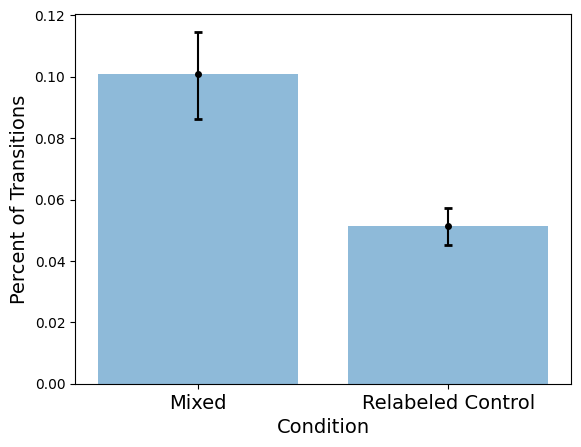

35it [00:03, 11.39it/s]


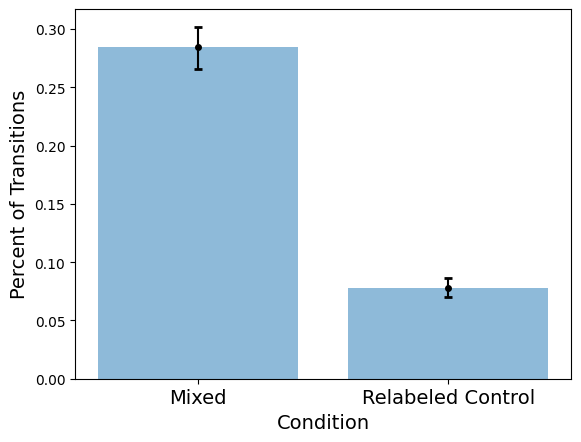

35it [00:00, 316.02it/s]


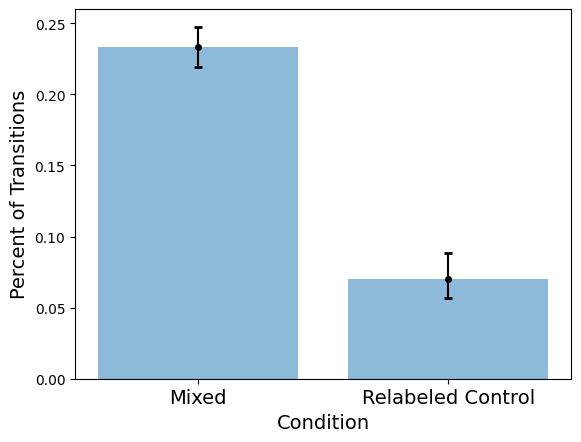

In [22]:
data_path = "data/{}.h5"
data_tag = "LohnasKahana2014"
trial_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"

data = load_data(data_path.format(data_tag))

# convert data entries back to numpy for now
data = {key: np.array(value) for key, value in data.items()}

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'])
plt.show()

trial_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'])
plt.show()

trial_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

### Simulated Data Results

We can perform the same analysis on simulated data from CMR fits to the Lohnas & Kahana (2014) dataset.

35it [00:02, 13.33it/s]


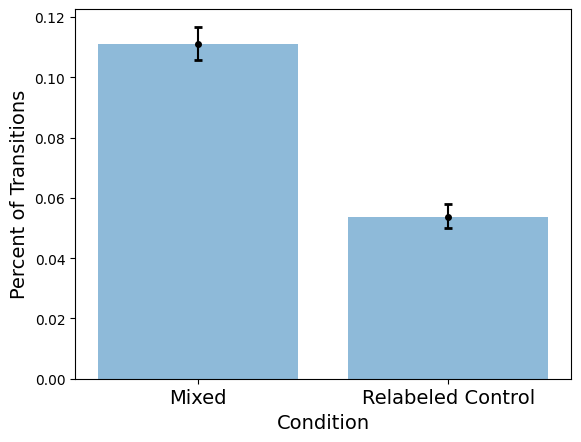

35it [00:03, 10.78it/s]


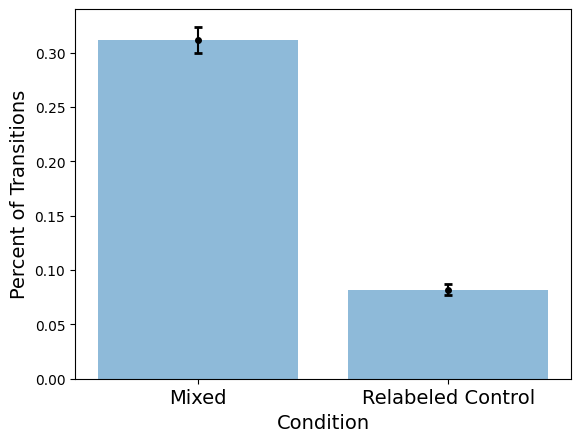

35it [00:04,  7.28it/s]


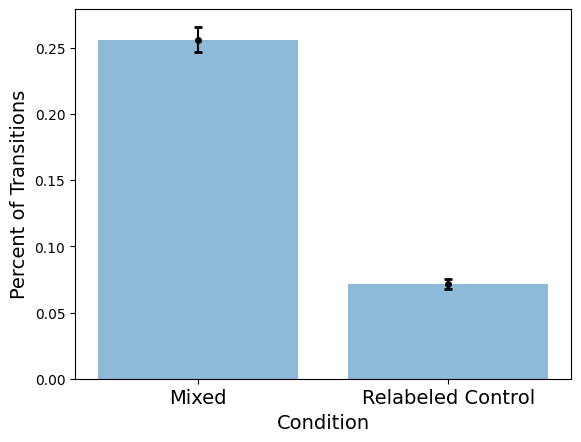

In [23]:
#| notest

import json
from jax import random
import jax.numpy as jnp
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.weird_cmr import BaseCMRFactory as weird_cmr_model_factory

seed = 0
experiment_count = 50

data_path = "data/{}.h5"
data_tag = "LohnasKahana2014"
trial_query = "data['list_type'] != 0"

data = load_data(data_path.format(data_tag))
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

fit_path = "fits/LohnasKahana2014_WeirdCMR_full_best_of_3.json"
with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]

rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
sim = simulate_h5_from_h5(
    model_factory=weird_cmr_model_factory,
    dataset=data,
    connections=connections,
    parameters={key: jnp.array(val) for key, val in results["fits"].items()},  # type: ignore
    trial_mask=trial_mask,
    experiment_count=experiment_count,
    rng=rng_iter,
)

#| notest

trial_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"

data = {key: np.array(value) for key, value in sim.items()}
trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

#| notest

trial_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

#| notest

trial_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

35it [00:02, 12.90it/s]


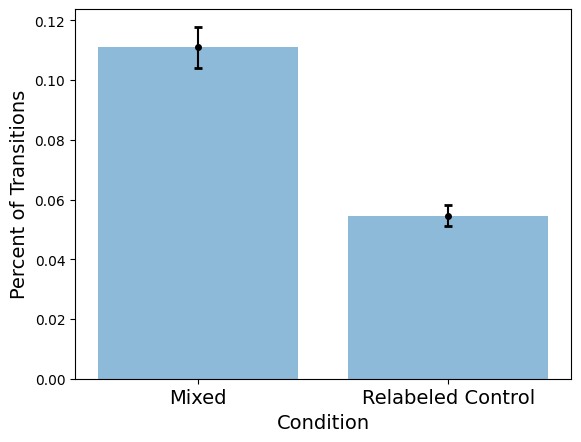

35it [00:03, 10.00it/s]


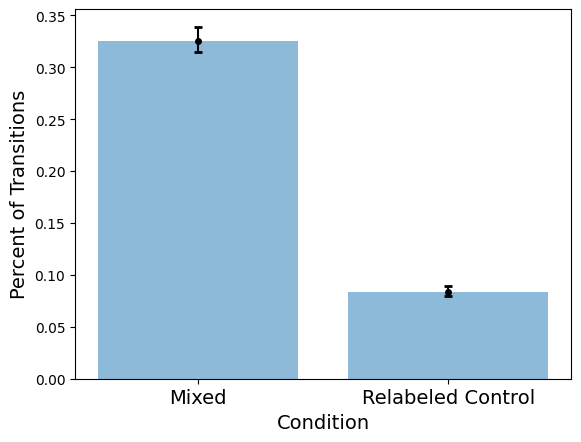

35it [00:04,  7.10it/s]


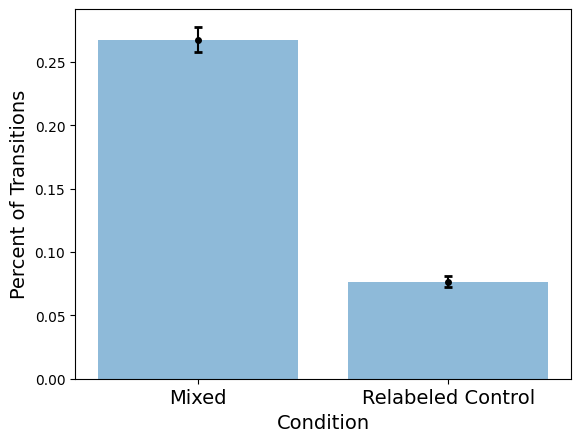

In [24]:
#| notest

import json
from jax import random
import jax.numpy as jnp
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.weird_no_reinstate_cmr import BaseCMRFactory as weird_no_reinstate_cmr_model_factory

seed = 0
experiment_count = 50

data_path = "data/{}.h5"
data_tag = "LohnasKahana2014"
trial_query = "data['list_type'] != 0"

data = load_data(data_path.format(data_tag))
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

fit_path = "fits/LohnasKahana2014_WeirdNoReinstateCMR_full_best_of_3.json"
with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]

rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
sim = simulate_h5_from_h5(
    model_factory=weird_no_reinstate_cmr_model_factory,
    dataset=data,
    connections=connections,
    parameters={key: jnp.array(val) for key, val in results["fits"].items()},  # type: ignore
    trial_mask=trial_mask,
    experiment_count=experiment_count,
    rng=rng_iter,
)

#| notest

trial_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"

data = {key: np.array(value) for key, value in sim.items()}
trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

#| notest

trial_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

#| notest

trial_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

35it [00:02, 11.68it/s]


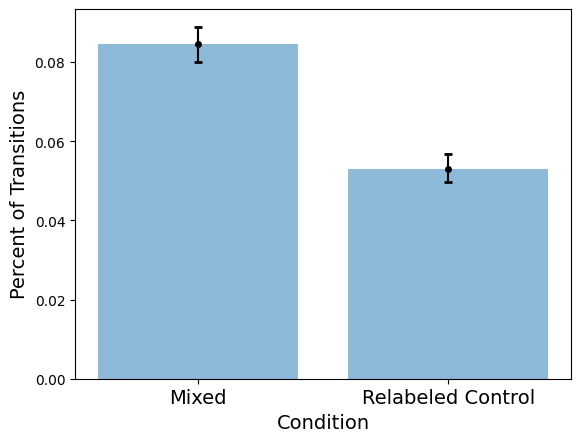

35it [00:03,  9.36it/s]


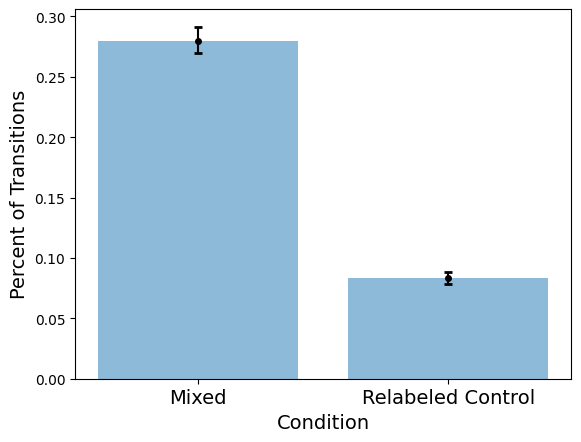

35it [00:05,  6.34it/s]


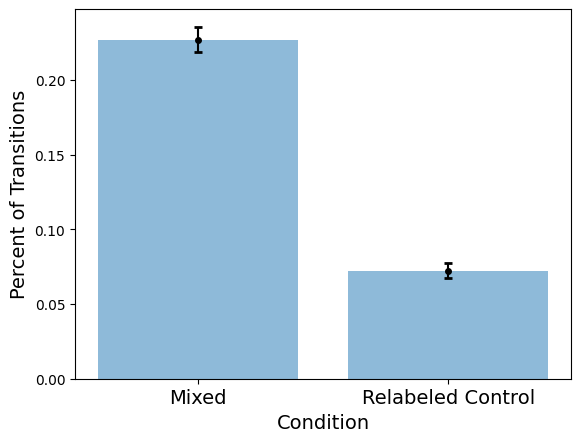

In [25]:
#| notest

import json
from jax import random
import jax.numpy as jnp
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.position_scale_cmr import BaseCMRFactory as position_scale_cmr_model_factory

seed = 0
experiment_count = 50

data_path = "data/{}.h5"
data_tag = "LohnasKahana2014"
trial_query = "data['list_type'] != 0"

data = load_data(data_path.format(data_tag))
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

fit_path = "fits/LohnasKahana2014_PositionScaleCMR_full_best_of_3.json"
with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]

rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
sim = simulate_h5_from_h5(
    model_factory=position_scale_cmr_model_factory,
    dataset=data,
    connections=connections,
    parameters={key: jnp.array(val) for key, val in results["fits"].items()},  # type: ignore
    trial_mask=trial_mask,
    experiment_count=experiment_count,
    rng=rng_iter,
)

#| notest

trial_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"

data = {key: np.array(value) for key, value in sim.items()}
trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

#| notest

trial_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

#| notest

trial_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

35it [00:03, 11.29it/s]


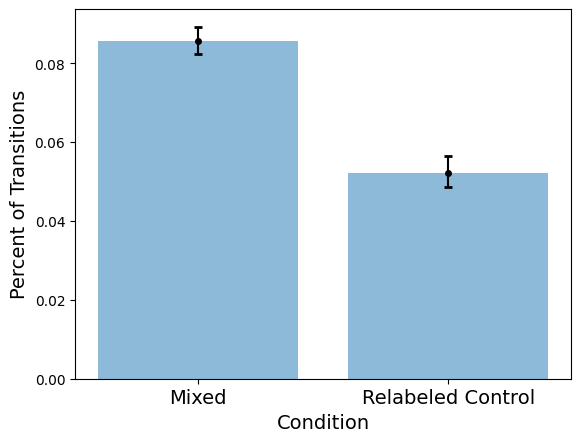

35it [00:03,  9.08it/s]


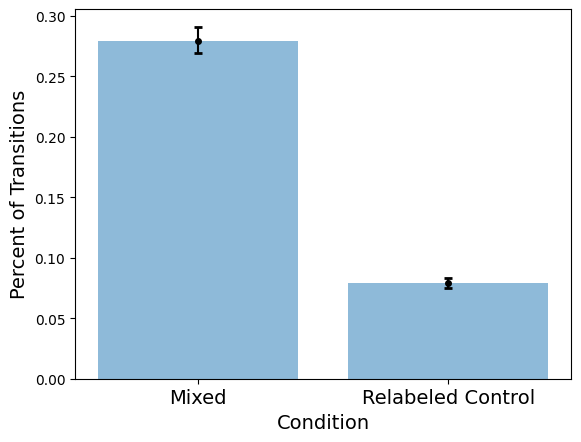

35it [00:05,  6.22it/s]


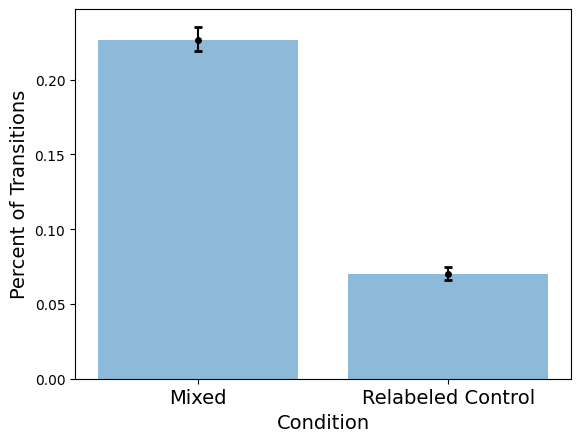

In [26]:
#| notest

import json
from jax import random
import jax.numpy as jnp
from jaxcmr.simulation import simulate_h5_from_h5
from jaxcmr.weird_position_scale_cmr import BaseCMRFactory as weird_position_scale_cmr_model_factory

seed = 0
experiment_count = 50

data_path = "data/{}.h5"
data_tag = "LohnasKahana2014"
trial_query = "data['list_type'] != 0"

data = load_data(data_path.format(data_tag))
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

fit_path = "fits/LohnasKahana2014_WeirdPositionScaleCMR_full_best_of_3.json"
with open(fit_path) as f:
    results = json.load(f)
    if "subject" not in results["fits"]:
        results["fits"]["subject"] = results["subject"]

rng = random.PRNGKey(seed)
rng, rng_iter = random.split(rng)
trial_mask = generate_trial_mask(data, trial_query)
sim = simulate_h5_from_h5(
    model_factory=weird_position_scale_cmr_model_factory,
    dataset=data,
    connections=connections,
    parameters={key: jnp.array(val) for key, val in results["fits"].items()},  # type: ignore
    trial_mask=trial_mask,
    experiment_count=experiment_count,
    rng=rng_iter,
)

#| notest

trial_query = "data['list_type'] == 4"
control_trial_query = "data['list_type'] == 1"

data = {key: np.array(value) for key, value in sim.items()}
trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

#| notest

trial_query = "data['list_type'] == 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()

#| notest

trial_query = "data['list_type'] >= 3"
control_trial_query = "data['list_type'] == 1"

trial_mask = generate_trial_mask(data, trial_query)
control_trial_mask = generate_trial_mask(data, control_trial_query)

plot_neighbor_contiguity(
    [data], [trial_mask], [control_trial_mask], labels=['Mixed', 'Relabeled Control'],
    control_experiment_count=1)
plt.show()